# DenseVAE: An example with tf.keras and eager

In [1]:
# to generate gifs
!pip install imageio

You are using pip version 19.0.3, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Import TensorFlow and enable Eager execution

In [14]:
# Import TensorFlow >= 1.9 and enable eager execution
import tensorflow as tf
tfe = tf.contrib.eager
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from som_vae.helpers.misc import extract_args, chunks, foldl
from som_vae.helpers.jupyter import fix_layout, display_video
from som_vae.settings import config, skeleton
from som_vae.helpers import video, plots, misc, jupyter
from som_vae import preprocessing
from som_vae.helpers.logging import enable_logging
from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_

In [15]:
jupyter.fix_layout()

## Load the MNIST dataset

Each MNIST image is originally a vector of 784 integers, each of which is between 0-255 and represents the intensity of a pixel. We model each pixel with a Bernoulli distribution in our model, and we statically binarize the dataset.

Remember they binarize the data previous.

In [18]:
from som_vae import settings
from som_vae import preprocessing

joint_positions, normalisation_factors = preprocessing.get_data_and_normalization(settings.data.EXPERIMENTS)

frames_idx_with_labels = preprocessing.get_frames_with_idx_and_labels(settings.data.LABELLED_DATA)[:len(joint_positions)]

#frames_of_interest = frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.GROOM_ANT, settings.data._BehaviorLabel_.WALK_FORW, settings.data._BehaviorLabel_.REST])
frames_of_interest = ~frames_idx_with_labels.label.isin([settings.data._BehaviorLabel_.REST])

joint_positions = joint_positions[frames_of_interest]
frames_idx_with_labels = frames_idx_with_labels[frames_of_interest]

In [19]:
# flatten the data
reshaped_joint_position = joint_positions[:,:,: config.NB_DIMS].reshape(joint_positions.shape[0], -1).astype(np.float32)


# scaling the data to be in [0, 1]
# this is due to the sigmoid activation function in the reconstruction
scaler = MinMaxScaler()
#resh = scaler.fit_transform(resh)

print(f"total number of input data:{reshaped_joint_position.shape}")


#if som_vae_config['time_series']:
#    _time_series_idx_ = list(to_time_series(range(len(joint_positions))))
#    _jp = np.concatenate([joint_positions[idx].reshape(1, -1, 30) for idx in _time_series_idx_], axis=0)
#else:
#    _jp = joint_positions
#    
#nb_of_data_points = (reshaped_joint_position.shape[0] // config['batch_size']) * config['batch_size']
# train - test split
nb_of_data_points = int(reshaped_joint_position.shape[0] * 0.7)
#
data_train = scaler.fit_transform(reshaped_joint_position[:nb_of_data_points])
data_test = scaler.transform(reshaped_joint_position[nb_of_data_points:])
# just generating some labels, no clue what they are for except validation?
#labels = frames_idx_with_labels['label'].apply(lambda x: x.value).values

#if som_vae_config['time_series']:
#    labels = np.concatenate([labels[idx].reshape(1, -1, 1) for idx in _time_series_idx_], axis=0)

#data = {
#  "X_train": data_train,
#  "X_val": data_test,
#  "y_train": labels[:nb_of_data_points],
#  "y_val": labels[nb_of_data_points:]
#}


total number of input data:(1538, 30)


In [20]:
TRAIN_BUF = len(data_train) 
BATCH_SIZE = 100

TEST_BUF = len(data_test) 

## Use *tf.data* to create batches and shuffle the dataset

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices(data_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices(data_test).shuffle(TEST_BUF).batch(BATCH_SIZE)

In [22]:
data_train.shape

(1076, 30)

## Wire up the generative and inference network with *tf.keras.Sequential*

### Generative Network
This defines the generative model which takes a latent encoding as input, and outputs the parameters for a conditional distribution of the observation, i.e. $p(x|z)$. Additionally, we use a unit Gaussian prior $p(z)$ for the latent variable.

### Inference Network
This defines an approximate posterior distribution $q(z|x)$, which takes as input an observation and outputs a set of parameters for the conditional distribution of the latent representation. In this example, we simply model this distribution as a diagonal Gaussian. In this case, the inference network outputs the mean and log-variance parameters of a factorized Gaussian (log-variance instead of the variance directly is for numerical stability).

### Reparameterization Trick
During optimization, we can sample from $q(z|x)$ by first sampling from a unit Gaussian, and then multiplying by the standard deviation and adding the mean. This ensures the gradients could pass through the sample to the inference network parameters.

### Network architecture
For the inference network, we use two convolutional layers followed by a fully-connected layer. In the generative network, we mirror this architecture by using a fully-connected layer followed by three convolution transpose layers (a.k.a. deconvolutional layers in some contexts). Note, it's common practice to avoid using batch normalization when training VAEs, since the additional stochasticity due to using mini-batches may aggravate instability on top of the stochasticity from sampling.

In [71]:
class CVAE(tf.keras.Model):
    def __init__(self, latent_dim, input_shape, batch_size):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim
        self._input_shape = input_shape
        self._batch_size = batch_size
        # `latent_dim + latent_dim` because of the splitting of the inference network's output
        self.inference_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=input_shape),
                                                  tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                                  tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                                  tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                                  tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                                  tf.keras.layers.Dense(latent_dim + latent_dim),
                                                 ])
    
        self.generative_net = tf.keras.Sequential([tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
                                                   tf.keras.layers.Dense(32, activation=tf.nn.relu),
                                                   tf.keras.layers.Dense(64, activation=tf.nn.relu),
                                                   tf.keras.layers.Dense(128, activation=tf.nn.relu),
                                                   tf.keras.layers.Dense(256, activation=tf.nn.relu),
                                                   tf.keras.layers.Dense(input_shape[0])])
    
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random_normal(shape=(self._batch_size, self.latent_dim))
        return self.decode(eps, apply_sigmoid=True)
  
    def encode(self, x):
        mean, logvar = tf.split(self.inference_net(x), num_or_size_splits=2, axis=1)
        return mean, logvar
  
    def reparameterize(self, mean, logvar):
        eps = tf.random_normal(shape=mean.shape)
        return eps * tf.exp(logvar * .5) + mean
  
    def decode(self, z, apply_sigmoid=False):
        logits = self.generative_net(z)
        if apply_sigmoid:
            probs = tf.sigmoid(logits)
            return probs
  
        return logits

    def predict(self, x):
        mean, logvar = self.encode(x)
        z = model.reparameterize(mean, logvar)
        return model.decode(z)

## Define the loss function and the optimizer

VAEs train by maximizing the evidence lower bound (ELBO) on the marginal log-likelihood:

$$\log p(x) \ge \text{ELBO} = \mathbb{E}_{q(z|x)}\left[\log \frac{p(x, z)}{q(z|x)}\right].$$

In practice, we optimize the single sample Monte Carlo estimate of this expectation:

$$\log p(x| z) + \log p(z) - \log q(z|x),$$
where $z$ is sampled from $q(z|x)$.

**Note**: we could also analytically compute the KL term, but here we incorporate all three terms in the Monte Carlo estimator for simplicity.

In [72]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.log(2. * np.pi)
    return tf.reduce_sum(
        -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
        axis=raxis)

def compute_loss(model, x):
    mean, logvar = model.encode(x)
    z = model.reparameterize(mean, logvar)
    x_logit = model.decode(z)
  
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    #logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
    logpx_z = -tf.reduce_sum(cross_ent, axis=[1]) # down to [batch, loss]
    logpz = log_normal_pdf(z, 0., 0.)
    logqz_x = log_normal_pdf(z, mean, logvar)
    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

def compute_gradients(model, x): 
    with tf.GradientTape() as tape: 
        loss = compute_loss(model, x) 
        return tape.gradient(loss, model.trainable_variables), loss

optimizer = tf.train.AdamOptimizer(1e-4)
def apply_gradients(optimizer, gradients, variables, global_step=None):
    optimizer.apply_gradients(zip(gradients, variables), global_step=global_step)

In [90]:
epochs = 400
latent_dim = 16 

num_examples_to_generate = 16

# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement.
random_vector_for_generation = tf.random_normal(
    shape=[num_examples_to_generate, latent_dim])
model = CVAE(latent_dim, input_shape=data_train.shape[1:], batch_size=BATCH_SIZE)

In [91]:
from som_vae.helpers.tensorflow import _TF_DEFAULT_SESSION_CONFIG_

In [92]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model.sample(test_input)
    fig = plt.figure(figsize=(4,4))
  
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0], cmap='gray')
        plt.axis('off')
  
    # tight_layout minimizes the overlap between 2 sub-plots
    #plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

#generate_and_save_images(model, 0, random_vector_for_generation)
sess = tf.InteractiveSession(config=_TF_DEFAULT_SESSION_CONFIG_)

losses = []
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in train_dataset:
        gradients, loss = compute_gradients(model, train_x)
        apply_gradients(optimizer, gradients, model.trainable_variables)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tfe.metrics.Mean()
        for test_x in test_dataset:
            loss(compute_loss(model, test_x))
        elbo = -loss.result()
        losses += [elbo]
        #display.clear_output(wait=False)
        if epoch % 10 == 0:
            print('Epoch: {:0>3}, Test set ELBO: {:0.3f}, '
                  'time elapse for current epoch {:0.4f}'.format(epoch,
                                                            elbo,
                                                            end_time - start_time))
            #generate_and_save_images(model, epoch, random_vector_for_generation)

/home/samuel/.local/lib/python3.7/site-packages/tensorflow/python/client/session.py:1702: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch: 010, Test set ELBO: -20.016, time elapse for current epoch 0.1217
Epoch: 020, Test set ELBO: -20.005, time elapse for current epoch 0.1240
Epoch: 030, Test set ELBO: -19.988, time elapse for current epoch 0.1211
Epoch: 040, Test set ELBO: -19.994, time elapse for current epoch 0.1217
Epoch: 050, Test set ELBO: -19.976, time elapse for current epoch 0.1219
Epoch: 060, Test set ELBO: -19.992, time elapse for current epoch 0.1211
Epoch: 070, Test set ELBO: -19.987, time elapse for current epoch 0.1215
Epoch: 080, Test set ELBO: -19.967, time elapse for current epoch 0.1216
Epoch: 090, Test set ELBO: -19.985, time elapse for current epoch 0.1225
Epoch: 100, Test set ELBO: -19.996, time elapse for current epoch 0.1217
Epoch: 110, Test set ELBO: -19.969, time elapse for current epoch 0.1214
Epoch: 120, Test set ELBO: -19.968, time elapse for current epoch 0.1225
Epoch: 130, Test set ELBO: -19.980, time elapse for current epoch 0.1211
Epoch: 140, Test set ELBO: -19.972, time elapse for

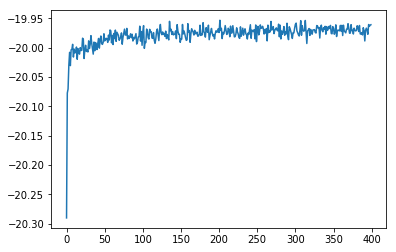

In [95]:
plt.plot(losses)

In [96]:
def _reverse_to_original_shape_(pos_data, input_shape=None):
    if input_shape is None:
        input_shape = (-1, config.NB_DIMS)
        
    return scaler.inverse_transform(pos_data).reshape(pos_data.shape[0], *(input_shape))

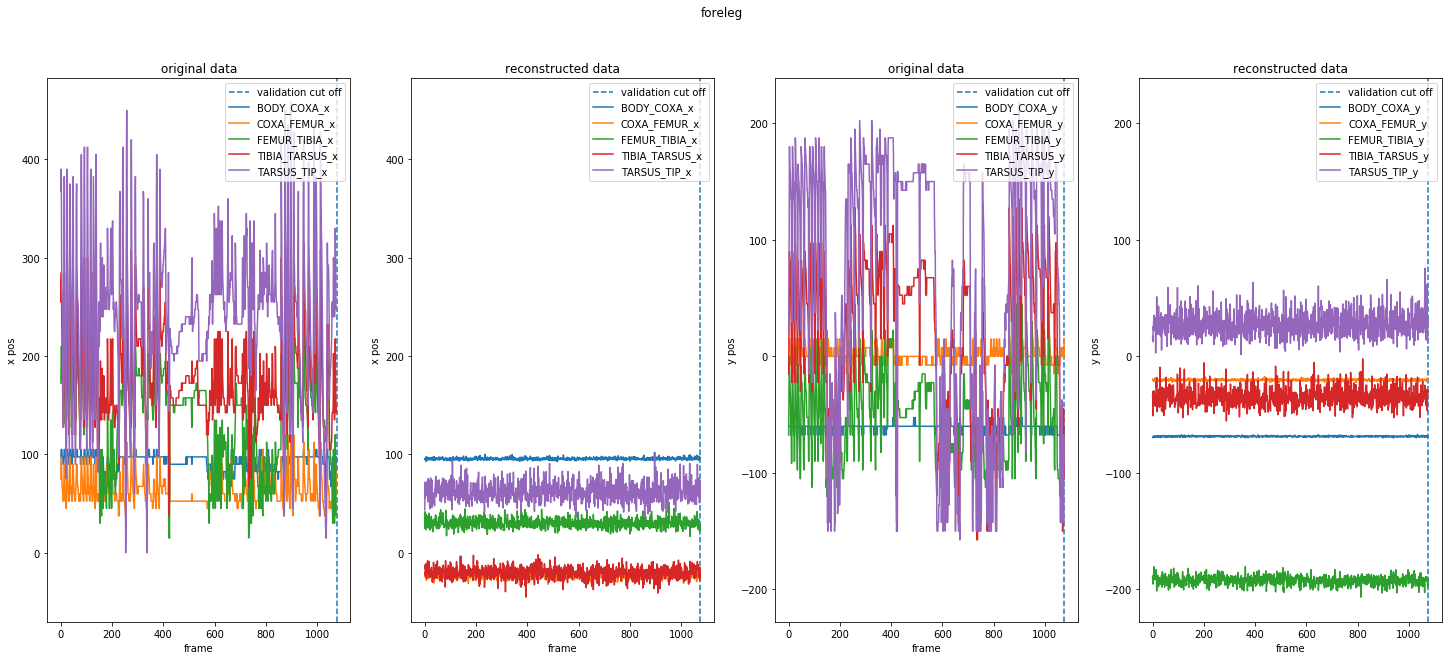

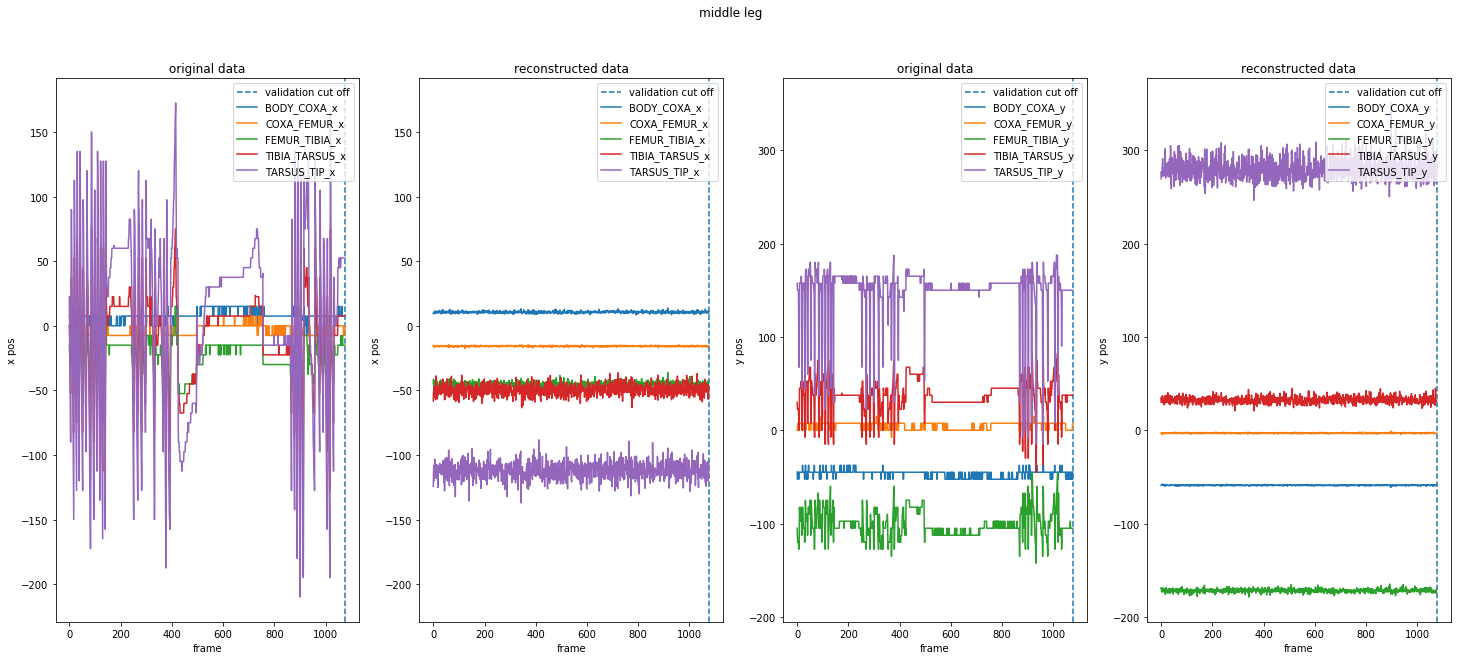

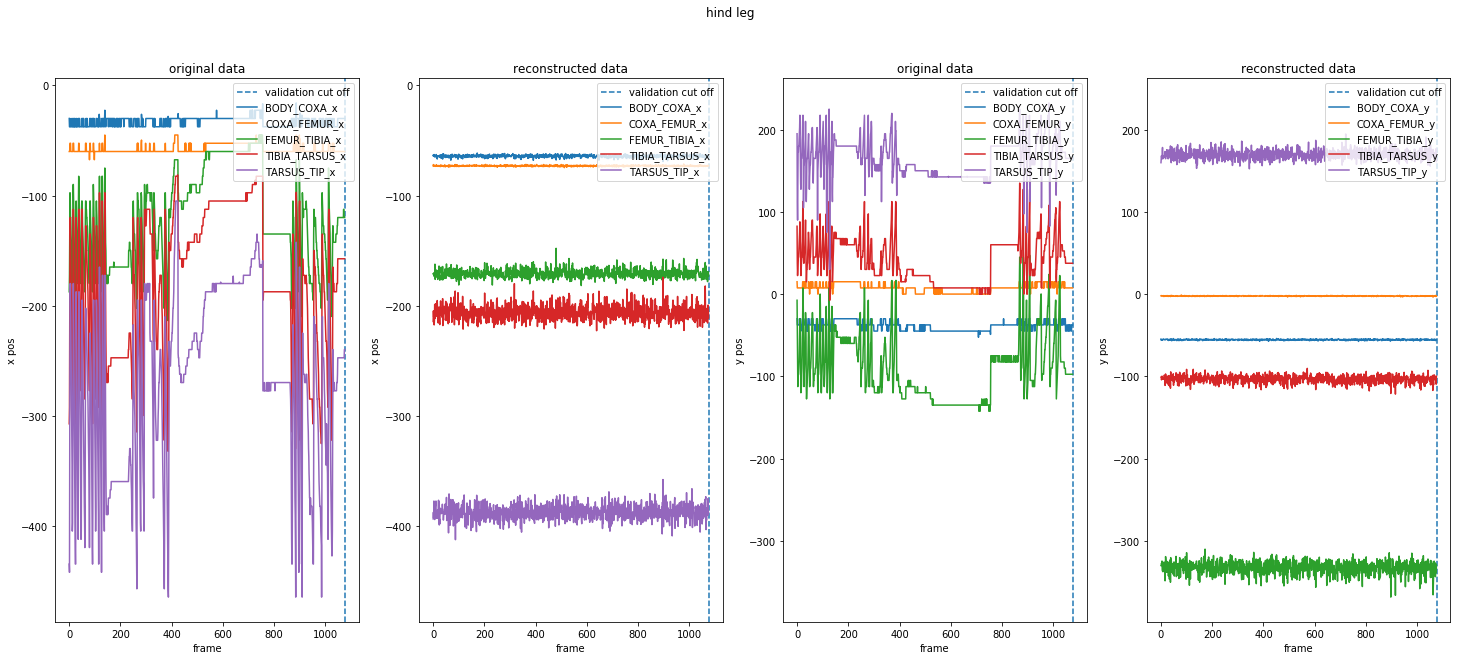

In [97]:
pred_train = model.predict(data_train)
pred_train_rev = _reverse_to_original_shape_(model.predict(data_train).numpy())

plots.plot_comparing_joint_position_with_reconstructed(_reverse_to_original_shape_(data_train), pred_train_rev, validation_cut_off=nb_of_data_points)